##### nsbh-remnant.ipynb

### *remnant matter contour plot from Foucart+ 2018 fit to NSBH merger simulations compared against estimated compact binary merger parameters*

this notebook plots contours of constant remnant mass (as a fraction of the neutron star baryonic mass) as a function of black hole spin in neutron star--black hole mergers according to the empirical formula from Foucart+ 2018, based on a suite of neutron star--black hole merger simulations, and overlays the estimated masses for a given candidate compact binary merger event

##### philippe landry (pgjlandry@gmail.com) 04/2024

In [1]:
# import packages

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import requests as rq
import json
import h5py
from src.utils import *
import src.fhn18 as fhn
from src.plot import *

plt.rcParams["text.usetex"] = False
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 16

In [2]:
# user input

F_threshold = 0.01

RNS = 12. # simulation values of the compactness range from 0.13 to 0.18
chiBHs = [-0.4,0.,0.4,0.6,0.8] # simulation values range from -0.5 to 0.97

q_range = (0.143,1.) # simulation values of the mass ratio range from 0.143 to 1.
C_range = (0.13,0.19) # simulation values of the compactness range from 0.13 to 0.182

mNS_range = ((1e5*c**2*RNS)/(G*Msol))*np.array(C_range) 
mBH_range = (mNS_range[1]/q_range[1],mNS_range[1]/q_range[0])

mNSgrid = (0.5,2.5)
mBHgrid = (2.5,10.5)

In [3]:
# get all gwosc nsbh events

GWOSC_PATH_WEB = 'https://gwosc.org/eventapi/json/allevents/'
GWOSC_PATH_LOCAL = 'etc/gwosc_table.json'

if not os.path.isfile(GWOSC_PATH_LOCAL):

    gwosc_web = rq.get(GWOSC_PATH_WEB,allow_redirects=True)
    with open(GWOSC_PATH_LOCAL,'wb') as outfile: outfile.write(gwosc_web.content)

with open(GWOSC_PATH_LOCAL) as infile: gwosc_table = json.load(infile)

SNR_THRESH = 10.
NS_MMAX = 2.5
ns_events, versions = {}, {}

for event in gwosc_table['events'].keys():
    
    snr = gwosc_table['events'][event]['network_matched_filter_snr']
    snr_err = gwosc_table['events'][event]['network_matched_filter_snr_upper']
    if snr is None: print('warning: field "network_matched_filter_snr" for {0} is empty!'.format(event)); continue
    elif snr_err is None: snr_err = 0.
    snr_ub = snr + snr_err
    
    m2 = gwosc_table['events'][event]['mass_2_source']
    m2_err = gwosc_table['events'][event]['mass_2_source_lower']
    if m2 is None: print('warning: field "mass_2_source" for {0} is empty!'.format(event)); continue
    elif m2_err is None: m2_err = 0.
    m2_lb = m2 + m2_err

    if m2_lb <= NS_MMAX and snr_ub >= SNR_THRESH:
        
        ns_events[event] = {}
        ns_events[event]['m1'] = gwosc_table['events'][event]['mass_1_source']
        ns_events[event]['m2'] = gwosc_table['events'][event]['mass_2_source']
        ns_events[event]['snr'] = gwosc_table['events'][event]['network_matched_filter_snr']
        ns_events[event]['name'] = gwosc_table['events'][event]['commonName']
        ns_events[event]['url'] = gwosc_table['events'][event]['jsonurl']

        try: versions[ns_events[event]['name']] += 1
        except: versions[ns_events[event]['name']] = 1

ns_events_keys = [event.split('-')[0]+'-v{0}'.format(versions[ns_events[event]['name']]) for event in ns_events.keys() if event[-1] == str(versions[ns_events[event]['name']])]
print(ns_events_keys)

['GW230529_181500-v1', 'GW200115_042309-v2', 'GW200105_162426-v2', 'GW190814_211039-v3', 'GW190426_152155-v1', 'GW190425_081805-v3']


In [7]:
# get pe samples for nsbh events

pe_metadata, pe_samples = {}, {}

for event in ns_events_keys:

    print(event)
    
    GWOSC_PATH_WEB = ns_events[event]['url']
    GWOSC_PATH_LOCAL = 'etc/gwosc_page.json'
    
    gwosc_web = rq.get(GWOSC_PATH_WEB,allow_redirects=True)
    with open(GWOSC_PATH_LOCAL,'wb') as outfile: outfile.write(gwosc_web.content)
    
    with open(GWOSC_PATH_LOCAL) as infile: gwosc_page = json.load(infile)
    os.remove(GWOSC_PATH_LOCAL)

    pe_key = [key for key in gwosc_page['events'][event]['parameters'].keys() if 'pe_combined' in key]
    if pe_key == []: ns_events_keys.remove(event); continue
    else: pe_key = pe_key[-1]
    
    wf_key = gwosc_page['events'][event]['parameters'][pe_key]['waveform_family']
    if wf_key == 'TDB:Mixed': wf_key = 'Combined_PHM_highSpin'
    pe_url = gwosc_page['events'][event]['parameters'][pe_key]['data_url']

    pe_metadata[event] = {}
    pe_metadata[event]['waveform'] = wf_key
    pe_metadata[event]['url'] = pe_url

    PE_PATH_WEB = pe_url
    PE_PATH_LOCAL = 'etc/{0}.h5'.format(event)

    if not os.path.isfile(PE_PATH_LOCAL):
    
        pe_web = rq.get(PE_PATH_WEB,allow_redirects=True)
        with open(PE_PATH_LOCAL,'wb') as outfile: outfile.write(pe_web.content)
        
    pe_data = h5py.File(PE_PATH_LOCAL, 'r')

    pe_samples[event] = {}
    
    #try:
    pe_samples[event]['m1'] = np.array(pe_data[wf_key]['posterior_samples'])['mass_1_source']
    pe_samples[event]['m2'] = np.array(pe_data[wf_key]['posterior_samples'])['mass_2_source']
    pe_samples[event]['chi1z'] = np.array(pe_data[wf_key]['posterior_samples'])['spin_1z']
    
    #except: print('warning: parameter estimation samples not found for {0}!'.format(event)); continue

print(pe_samples.keys())

GW230529_181500-v1
GW200115_042309-v2
GW200105_162426-v2
GW190814_211039-v3
GW190425_081805-v3
dict_keys(['GW230529_181500-v1', 'GW200115_042309-v2', 'GW200105_162426-v2', 'GW190814_211039-v3', 'GW190425_081805-v3'])


/tmp/ipykernel_181120/1277823425.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  COLORS = cm.get_cmap('PuBuGn_r',len(ns_events_keys)+3)
/tmp/ipykernel_181120/1277823425.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(pe_samples[event]['m2'][idxs],pe_samples[event]['m1'][idxs],marker='.',s=2,c=COLORS(i),alpha=0.2,zorder=1)


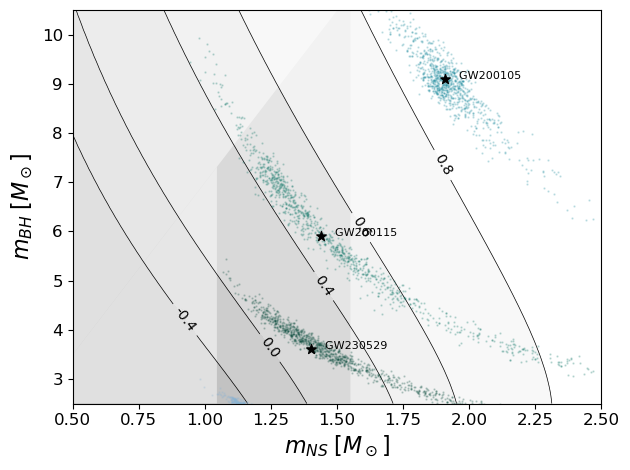

In [8]:
# make contour plot

NUM_SCATTER = 1000
COLORS = cm.get_cmap('PuBuGn_r',len(ns_events_keys)+3)

plt.figure()

remnant_mass_contour_plot(mBHgrid,mNSgrid,chiBHs,RNS,F_threshold,mBHrange=mBH_range,mNSrange=mNS_range,qrange=q_range,model=fhn.F_remnant)

for i,event in enumerate(pe_samples.keys()):

    plt.scatter(ns_events[event]['m2'],ns_events[event]['m1'],marker='*',s=50,c='k',zorder=2)
    plt.annotate('    '+ns_events[event]['name'].split('_')[0],(ns_events[event]['m2'],ns_events[event]['m1']),fontsize=8)

    idxs = np.random.choice(range(len(pe_samples[event]['m1'])),NUM_SCATTER)
    plt.scatter(pe_samples[event]['m2'][idxs],pe_samples[event]['m1'][idxs],marker='.',s=2,c=COLORS(i),alpha=0.2,zorder=1)

plt.tight_layout()
plt.show()

In [6]:
# next, overlay gwtc-3 population contours
# then add bns version
# then make interactive